In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys
from tqdm.auto import tqdm

from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

# Load Neural Data

In [3]:
session = 'Lucky-08032018'

session_data = dict(
    preOddball=dict(
        session_name = '-'.join([session.split('-')[0], 'preOddball', session.split('-')[1], '001'])
    ),
    Anesthesia=dict(
        session_name = '-'.join([session.split('-')[0], 'Anesthesia', session.split('-')[1], '002'])
    ),
    postOddball=dict(
        session_name = '-'.join([session.split('-')[0], 'postOddball', session.split('-')[1], '001'])
    )
)

In [4]:
all_data_dir = '/millerdata/data/common/datasets/anesthesia/mat'
for section in tqdm(session_data.keys(), total=len(session_data.keys())):
    section_session = session_data[section]['session_name']
    data_class = get_data_class(section_session, all_data_dir)
    
    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    session_vars, T, N, dt = load_session_data(section_session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']
    vars_dict = dict(
        electrode_info=electrode_info,
        lfp=lfp,
        lfp_schema=lfp_schema,
        session_info=session_info,
        trial_info=trial_info,
        unit_info=unit_info
    )
    session_data[section] = session_data[section] | vars_dict

  0%|          | 0/3 [00:00<?, ?it/s]

# Explore

In [6]:
area = 'PFC'
for section in tqdm(session_data.keys(), total=len(session_data.keys())):
    if area == 'all':
        unit_indices = np.arange(len(session_data[section]['electrode_info']['area']))
    else:
        unit_indices = np.where([area.lower() in a.lower() for a in session_data[section]['electrode_info']['area']])[0]
    
    t = int(session_data[section]['lfp'].shape[0]/2)
    signal = session_data[section]['lfp'][t:t + 20000, unit_indices]
    delase = DeLASE(signal[:15000], dt=dt, p=int(6400/len(unit_indices)), use_torch=True, device='cuda')

    delase.compute_havok_dmd(r_thresh=0.01, lamb=1e-2)
    preds = delase.predict_havok_dmd(signal[15000:], tail_bite=True, reseed=50)
    ip_ret = compute_integrated_performance(delase, signal[15000:], full_return=True, verbose=True)

    delase.compute_jacobians()
    delase.get_stability(max_freq=500, max_unstable_freq=125)

    session_data[section]['return'] = dict(
        ip_ret=ip_ret,
        stability_params=delase.stability_params.cpu()
    )

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

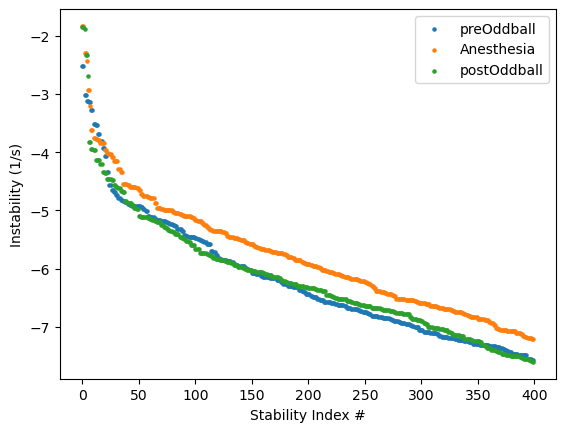

In [7]:
for section in session_data.keys():
    plt.scatter(np.arange(400), session_data[section]['return']['stability_params'][:400].cpu(), label=section, s=5)
plt.xlabel('Stability Index #')
plt.ylabel('Instability (1/s)')
plt.legend()
plt.show()

In [85]:
# plt.plot(signal[15000:, 0])
# plt.plot(preds[:, 0].cpu())